# What's new in the RDKit since the 2014 UGM?
## RDKit 2015 UGM, Zürich Switzerland

Greg Landrum, Ph.D.

NIBR Informatics

Novartis Institutes for BioMedical Research

Basel Switzerland

## General
  - Performance improvements and reductions in memory usage
  - MyChEMBL now distributing RDKit tutorials as IPython notebooks (https://github.com/chembl/mychembl/tree/master/ipython_notebooks)
  
  

## Contrib Area
  - NP_Score: natural-product likeness score from Peter Ertl. More on this from Peter later.

## New Feature Highlights
  - A new algorithm for canonical atom orders. More on this from Nadine Schneider later.
  - C++-based molecule drawing code
  - Torsion fingerprint difference implementation for comparing 3D conformations.
  - New FilterCatalog functionality for using substructure filters. More on this from Brian in a lightning talk
  - Multi-threaded execution of some computationally expensive functions
  - The RWMol class has replaced EditableMols in Python
  - FMCS functionality now available in the PostgreSQL cartridge
  - MolKey calculator to help with registration. More on this from Greg in a lightning talk
  - Improved conformation generation using information about experimental torsions is now possible. More on this from Sereina Riniker later.
  - Curated, RDKit-compatible list of PAINS filters included in distribution
  


## Demos

In [1]:
from __future__ import print_function
import gzip
from rdkit import Chem
from rdkit.Chem import Draw,AllChem
from rdkit.Chem.Draw import IPythonConsole
%load_ext sql

/Library/Python/2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/Library/Python/2.7/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/Library/Python/2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


### New depictor code

The new depiction is written in C++, allowing access to consistent depictions from Python, C++, Java (i.e. KNIME), etc.

In [2]:
# Start by importing some code to allow the depiction to be used:
from IPython.display import SVG
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D

# a function to make it a bit easier. This should probably move to somewhere in
# rdkit.Chem.Draw
def _prepareMol(mol,kekulize):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    return mc
def moltosvg(mol,molSize=(450,200),kekulize=True,drawer=None,**kwargs):
    mc = _prepareMol(mol,kekulize)
    if drawer is None:
        drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc,**kwargs)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    # It seems that the svg renderer used doesn't quite hit the spec.
    # Here are some fixes to make it work in the notebook, although I think
    # the underlying issue needs to be resolved at the generation step
    return SVG(svg.replace('svg:',''))

from io import BytesIO
from PIL import Image
def moltopng(mol,molSize=(450,200),kekulize=True,drawer=None,**kwargs):
    mc = _prepareMol(mol,kekulize)
    if drawer is None:
        drawer = rdMolDraw2D.MolDraw2DCairo(molSize[0],molSize[1])
    drawer.DrawMolecule(mc,**kwargs)
    drawer.FinishDrawing()
    sio = BytesIO(drawer.GetDrawingText())
    return Image.open(sio)

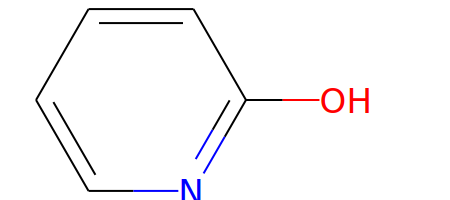

In [3]:
m = Chem.MolFromSmiles('c1cccnc1O')
moltosvg(m)

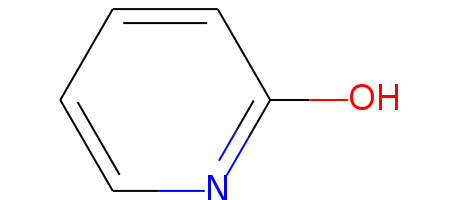

In [5]:
m = Chem.MolFromSmiles('c1cccnc1O')
moltopng(m)

In [6]:
import glob
pkls = glob.glob('/Users/landrgr1/Code/benchmarking_platform/compounds/ChEMBL_II/*.pkl')
import pickle
sets = pickle.load(open(pkls[0]))
smis=sets.values()[0]
ms = [Chem.MolFromSmiles(y) for x,y in smis]

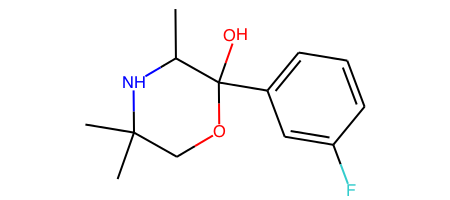

In [7]:
m = ms[1]
rdDepictor.Compute2DCoords(m)
moltopng(m)

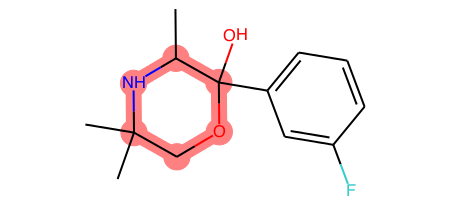

In [8]:
moltopng(m,highlightAtoms=m.GetSubstructMatch(Chem.MolFromSmarts('C1CNCCO1')))

Highlighting individual atoms:

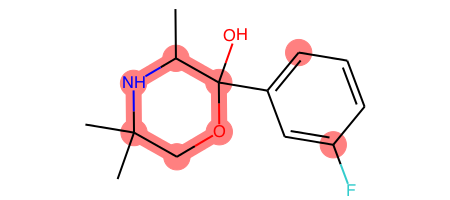

In [9]:
highlight=list(m.GetSubstructMatch(Chem.MolFromSmarts('C1CNCCO1'))) + [11,14]
moltopng(m,highlightAtoms=highlight)

We can modify the highlighting colors:

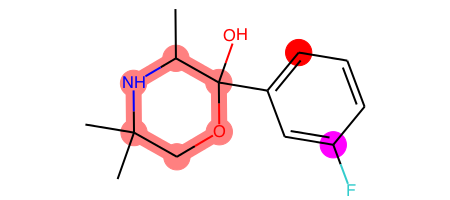

In [43]:
highlight=list(m.GetSubstructMatch(Chem.MolFromSmarts('C1CNCCO1'))) + [11,14]
colors={11:(1,0,0), 14:(1,0,1)}
moltopng(m,highlightAtoms=highlight,highlightAtomColors=colors)

Highlighting atoms without highlighting bonds:

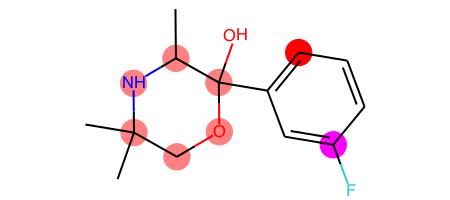

In [44]:
highlight=list(m.GetSubstructMatch(Chem.MolFromSmarts('C1CNCCO1'))) + [11,14]
colors={11:(1,0,0), 14:(1,0,1)}
moltopng(m,highlightAtoms=highlight,highlightAtomColors=colors,highlightBonds=[])

Changing bond highlight colors

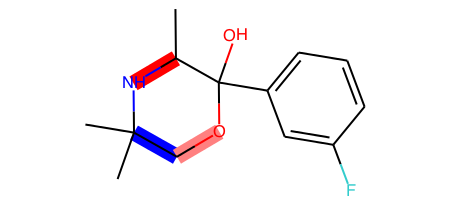

In [45]:
highlight=[1,5,6]
colors={1:(1,0,0), 4:(0,1,0), 5:(0,0,1), 10:(1,0,1)}
moltopng(m,highlightAtoms=[],highlightBonds=highlight,highlightBondColors=colors)

Customizing atom labels

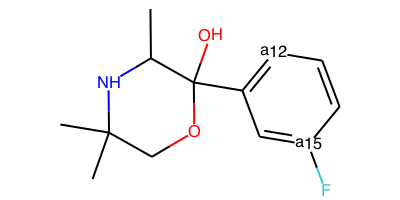

In [49]:
drawer = rdMolDraw2D.MolDraw2DCairo(400,200)
opts = drawer.drawOptions()
opts.atomLabels[11]='a12'
opts.atomLabels[14]='a15'
moltopng(m,drawer=drawer)

Taking that relabelling a step too far:

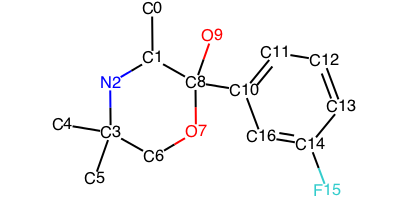

In [52]:
drawer = rdMolDraw2D.MolDraw2DCairo(400,200)
opts = drawer.drawOptions()

for i in range(m.GetNumAtoms()):
    opts.atomLabels[i] = m.GetAtomWithIdx(i).GetSymbol()+str(i)
moltopng(m,drawer=drawer)

### MCS integration into the cartridge

This [is documented](http://www.rdkit.org/docs/Cartridge.html#using-the-mcs-code) but it's worth demonstrating here.

In [3]:
sma = %sql postgresql://localhost/chembl_20 \
    select fmcs(m::text) from rdk.mols join compound_records using (molregno) where doc_id=3;
sma

1 rows affected.


fmcs
[#8]=[#6](-[#7]-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#6](=[#8])-[#7](-[#6]-[#6]-[#6])-[#6]1:[#6]:[#6]:[#16]:[#6]:1)-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1


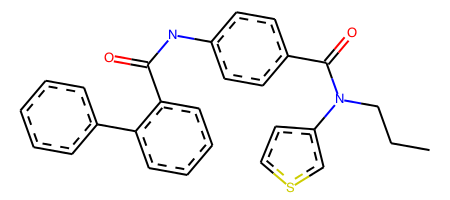

In [4]:
moltopng(Chem.MolFromSmarts(sma[0][0]))

Providing parameters is still a bit painful:

In [5]:
sma = %sql \
  select fmcs(canonical_smiles) from compound_structures join \
    compound_records using (molregno) where doc_id=4;
sma

1 rows affected.


fmcs
"[#6](-[#7]-[#6]-[#6]-,:[#6]-,:[#6]-,:[#6]-,:[#6])-[#6](-,:[#6])-,:[#6]"


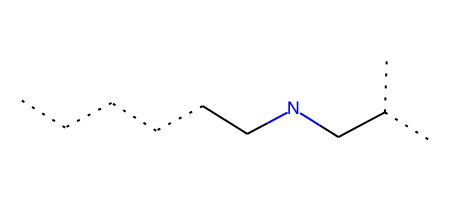

In [6]:
moltopng(Chem.MolFromSmarts(sma[0][0]))

In [7]:
sma = %sql \
   select fmcs_smiles(str,'{"Threshold" : 0.8}') from \
       (select string_agg(canonical_smiles,' ') as str from compound_structures \
       join compound_records using (molregno) where doc_id=4) as str ;
sma

1 rows affected.


fmcs_smiles
"[#6]-[#6](-[#7]-[#6](=[#8])-[#6](-[#8]-[#6]-[#6])-[#6](-[#8])-[#6](-[#8])-[#6](-[#8]-[#6]-[#6])-[#6]-[#7]-[#6](-[#6](-,:[#6])-,:[#6])-[#6])-[#6](-,:[#6])-,:[#6]"


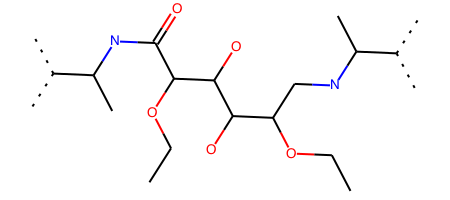

In [8]:
moltopng(Chem.MolFromSmarts(sma[0][0]))

In [4]:
sma = %sql \
   select fmcs_smiles(str,'{"AtomCompare" : "Any","CompleteRingsOnly" : true}') from \
       (select string_agg(canonical_smiles,' ') as str from compound_structures \
       join compound_records using (molregno) where doc_id=4) as str ;
sma

1 rows affected.


fmcs_smiles
"[#6]-[#7,#6]-[#6,#7,#8]-[#6,#7](-[#7,#6]-[#6,#7]-[#6](-[#8,#6,#7]-[#6]-[#6,#7])-[#6]-[#6,#7,#8])-[#6,#8]-[#6,#7]"


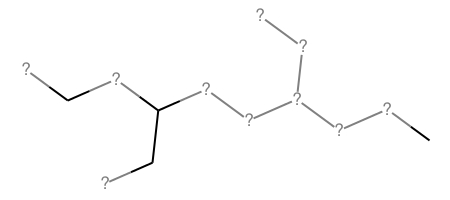

In [18]:
moltopng(Chem.MolFromSmarts(sma[0][0]))

### PandasTools Improvements

In [2]:
import pandas as pd # Import pandas
from rdkit.Chem import PandasTools
inf = gzip.open('./data/zim.sdf.gz','r')
cpds = PandasTools.LoadSDF(inf, includeFingerprints=True)
from rdkit.Chem import Descriptors
cpds['logp'] = cpds['ROMol'].map(Descriptors.MolLogP)
cpds['mw'] = cpds['ROMol'].map(Descriptors.MolWt)

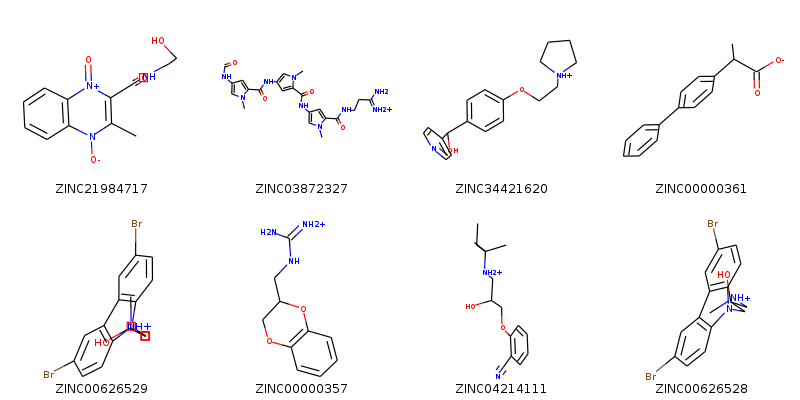

In [3]:
PandasTools.FrameToGridImage(cpds.head(8), legendsCol="ID", molsPerRow=4)

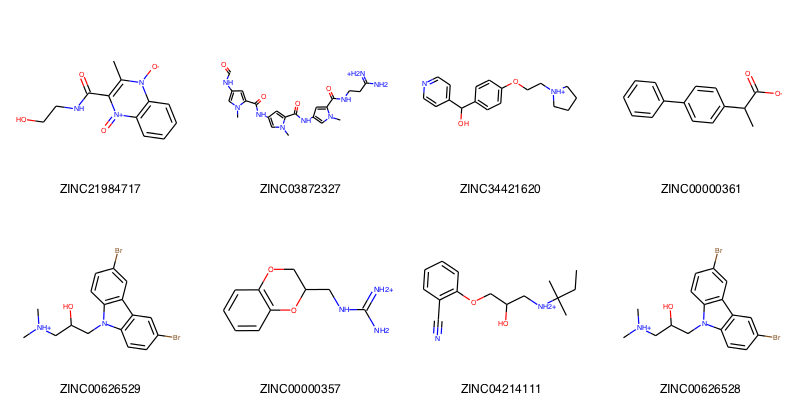

In [22]:
cpds['ROMol'].map(AllChem.Compute2DCoords)
PandasTools.FrameToGridImage(cpds.head(8), legendsCol="ID", molsPerRow=4)

ID                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
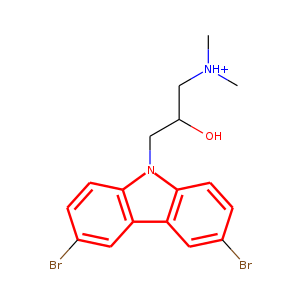
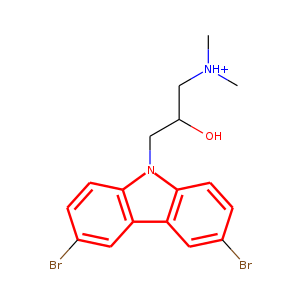
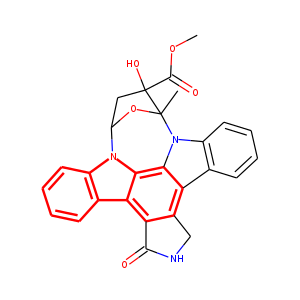
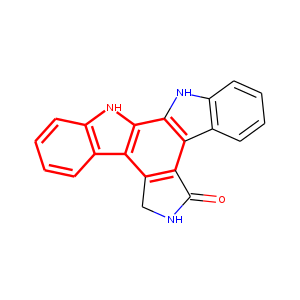
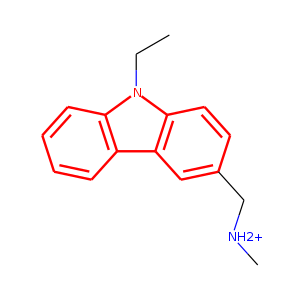

In [4]:
carbazoles = cpds[cpds.ROMol>=Chem.MolFromSmiles('c1cccc2Nc3ccccc3c12')]
carbazoles.ROMol.map(lambda x:PandasTools.AlignMol(x,'c1cccc2Nc3ccccc3c12'))
carbazoles.head()

We can write data frames to SDF files:

In [24]:
PandasTools.WriteSDF(carbazoles,'data/out1.sdf')

## Multithreaded execution

We tend to have multiple cores in our machines, why not use them?

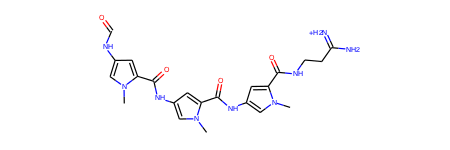

In [34]:
tm = list(cpds[cpds.ID=='ZINC03872327']['ROMol'])[0]
tm

In [37]:
mh = Chem.AddHs(tm)
%timeit AllChem.EmbedMultipleConfs(mh,numConfs=200)

1 loops, best of 3: 4.18 s per loop


In [39]:
mh = Chem.AddHs(tm)
%timeit AllChem.EmbedMultipleConfs(mh,numConfs=200,numThreads=4)

1 loops, best of 3: 1.04 s per loop


In [40]:
mn = Chem.Mol(mh)
%timeit AllChem.UFFOptimizeMoleculeConfs(mn)

1 loops, best of 3: 5.86 s per loop


In [51]:
mn = Chem.Mol(mh)
%timeit AllChem.UFFOptimizeMoleculeConfs(mn,numThreads=4)

1 loops, best of 3: 1.57 s per loop


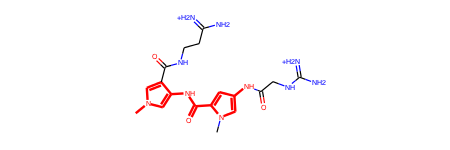

In [56]:
tm = list(cpds[cpds.ROMol >= \
    Chem.MolFromSmarts('a1a(*)aa(C(=*)*a2aa(*)aa2)a1')]['ROMol'])[1]
tm


In [57]:
tmh= Chem.AddHs(tm)
AllChem.EmbedMolecule(tmh)
AllChem.UFFOptimizeMolecule(tmh)
%timeit algs = AllChem.GetO3AForProbeConfs(Chem.Mol(mn),tmh)

1 loops, best of 3: 9.56 s per loop


In [58]:
%timeit algs = AllChem.GetO3AForProbeConfs(Chem.Mol(mn),tmh,numThreads=4)

1 loops, best of 3: 2.7 s per loop


## Curated PAINS filters

There's [a blog post](http://rdkit.blogspot.ch/2015/08/curating-pains-filters.html) about this, but the basic idea is that there is now a curated version of that standard [SMARTS PAINS filters](http://onlinelibrary.wiley.com/doi/10.1002/minf.201100076/full) in `$RDBASE/Data/Pains`. The curated filters should be much more accurate when used on molecules that do not contains H atoms in the graph.

I strongly recommend using these with the RDKit instead of the original version.

## New MolKey calculation

Basics:

In [1]:
from rdkit.Chem.MolKey import MolKey
from rdkit.Avalon import pyAvalonTools

In [6]:
for smi in ('c1ccccc1C(F)Cl','c1ccccc1[C@H](F)Cl','c1ccccc1[C@@H](F)Cl'):
    res = MolKey.GetKeyForCTAB(pyAvalonTools.Generate2DCoords(smi,True))
    print(smi,"\t",res.mol_key,"\t",res.stereo_code)

c1ccccc1C(F)Cl 	 1|L7676nfGsSIU33wkx//NCg== 	 R_ONE
c1ccccc1[C@H](F)Cl 	 1|Aj38EIxf13RuPDQG2A0UMw== 	 S_ABS
c1ccccc1[C@@H](F)Cl 	 1|9ypfMrhxn1w0ncRooN5HXw== 	 S_ABS


### Providing a stereo code to indicate additional information

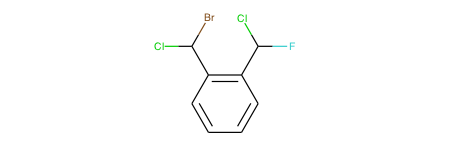

In [18]:
Chem.MolFromSmiles('c1cccc(C(Br)Cl)c1C(F)Cl')

In [12]:
res=MolKey.GetKeyForCTAB(pyAvalonTools.Generate2DCoords('c1cccc(C(Br)Cl)c1C(F)Cl',isSmiles=True))
print(res.mol_key,"\t",res.stereo_code,"\t",res.inchi)
res=MolKey.GetKeyForCTAB(pyAvalonTools.Generate2DCoords('c1cccc(C(Br)Cl)c1C(F)Cl',isSmiles=True),stereo_info='S_REL')
print(res.mol_key,"\t",res.stereo_code," \t",res.inchi)

1|5H9R3LvclagMXHp3Clrc/g== 	 S_UNKN 	 InChI=1/C8H6BrCl2F/c9-7(10)5-3-1-2-4-6(5)8(11)12/h1-4,7-8H/t7?,8?
1|cqKWVsUEY6QNpGCbDaDTYA== 	 S_REL  	 InChI=1/C8H6BrCl2F/c9-7(10)5-3-1-2-4-6(5)8(11)12/h1-4,7-8H/t7?,8?


### Use of the stereo comment

Distinguishing between "I really don't know" and "I know quite a lot, but there's one critical piece missing"

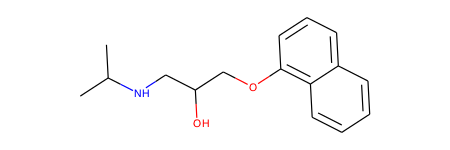

In [20]:
# using propanolol as an example
Chem.MolFromSmiles('CC(NCC(O)COC1=C(C=CC=C2)C2=CC=C1)C')

In [17]:
res=MolKey.GetKeyForCTAB(pyAvalonTools.Generate2DCoords('CC(NCC(O)COC1=C(C=CC=C2)C2=CC=C1)C',isSmiles=True))
print(res.mol_key,"\t",res.stereo_code," \t",res.inchi)
res=MolKey.GetKeyForCTAB(pyAvalonTools.Generate2DCoords('CC(NCC(O)COC1=C(C=CC=C2)C2=CC=C1)C',isSmiles=True),
                        stereo_info='S_UNKN',stereo_comment='First fraction from a CelluCoat column')
print(res.mol_key,"\t",res.stereo_code,"\t",res.inchi)
res=MolKey.GetKeyForCTAB(pyAvalonTools.Generate2DCoords('CC(NCC(O)COC1=C(C=CC=C2)C2=CC=C1)C',isSmiles=True),
                        stereo_info='S_UNKN',stereo_comment='Second fraction from a CelluCoat column')
print(res.mol_key,"\t",res.stereo_code,"\t",res.inchi)

1|YCnLJ7H8f5m08jFRalJcMA== 	 R_ONE  	 InChI=1/C16H21NO2/c1-12(2)17-10-14(18)11-19-16-9-5-7-13-6-3-4-8-15(13)16/h3-9,12,14,17-18H,10-11H2,1-2H3/t14?
1|P0tK60igohmGJWIpiDllUA== 	 S_UNKN 	 InChI=1/C16H21NO2/c1-12(2)17-10-14(18)11-19-16-9-5-7-13-6-3-4-8-15(13)16/h3-9,12,14,17-18H,10-11H2,1-2H3/t14?
1|iS8Z1apgvVXcaPd3n/xj9A== 	 S_UNKN 	 InChI=1/C16H21NO2/c1-12(2)17-10-14(18)11-19-16-9-5-7-13-6-3-4-8-15(13)16/h3-9,12,14,17-18H,10-11H2,1-2H3/t14?
